# Multi-armed bandits

In this task you are going to implement ETC and UCB. Then you will play around the parameters in order to draw some more conclusion.

Outline:
* Simulator writing
* ETC and experiments
* UCB and experiments

## Bulding a simulator for the bandit

In [15]:
from matplotlib import pyplot as plt
import numpy as np  # we can use this library for working with matrices
from statistics import mean # for dict mean

In [16]:
class Bandit:
    def __init__(self, k, means, rounds):
        # we assume Gaussian distributions with sigma=1
        self.k = k  # number of arms
        self.means = np.random.normal(means) # For converting it into gaussian distribution
        self.rounds = rounds  # number of available rounds
        
        # ----- chose the optimal reward -----
        self.optimal_reward = np.mean(self.means) # An ideal reward is always near to 1
        self.counter = 0
        # gather the empirical regret so far
        self.empirical_regret = 0
        self.emp_regrets = []
        # gather the expected regret so far
        self.expected_regret = 0
        self.exp_regrets = []
    
    def play_arm(self, arm):
        
        # ----- sample the appropriate reward -----
        reward = np.random.normal(self.means[arm], 1)      # Since we assume gaussian distribution of 1 so unit variance sigma * int + mu

        # ----- calculate the regret so far and save it -----
        
        # Empirical regret will be difference of optimal reward and present reward
        self.empirical_regret = reward  - self.optimal_reward
        self.emp_regrets.append(self.empirical_regret)
        
        # Expected regret will be difference of mean empirical reward and present reward
        self.expected_regret = np.mean(self.emp_regrets)
        self.exp_regrets.append(self.expected_regret)
        
        # Set the counter
        self.counter = self.counter + 1
        return reward
    
    def finished(self):
        # ----- return if there is no more round remained -----
        if self.counter >= self.rounds:
            return 
    
    def plot_regret(self):
        plt.plot(list(range(self.counter)), self.emp_regrets, 'b+', list(range(self.counter)), self.exp_regrets, 'ro')
        plt.xlabel("iteration")
        plt.ylabel("regret")
        plt.show()

## ETC algorithm

In [17]:
class ETCsolver:
    def __init__(self, k, m, bandit):
        self.k = k  # number of arms
        self.m = m  # number of exploration rounds for each arm
        self.bandit = bandit
        
        # ----- create a cache storing the number of trials and the average rewards -----
        
        # for each action
        self.cache = {}   # Making a dict 'key' for each arm
        for i in range(self.k):
            self.cache[i] = []
    
    def _exploration_phase(self):
        
        counter = 1  # Counter for stopping

        while counter < self.k * self.m:
            # ----- implement the exploration part -----
            
            # play the bandit and update cache
            reward = self.bandit.play_arm(counter)  # We play with random variable count for each counter
            
            # Let's get the "arm"
            key = int(counter // self.m)            # Key of dict for storing values
            
            # Appending all value of arm
            self.cache[key].append(reward)          # let's see for each arm what's the reward
            
            counter = counter + 1                   # Stop the counter
            
        #print(self.cache)
           
    
    def _choose_best_action(self):
        # ----- we calculate the average reward of each arm -----
        # return the best arm
        
        # Let's get the keys
        keys   = list(self.cache.keys())
        
        best = []  # For storing best keys
        for k in keys:
            r = np.mean(self.cache[k])         # Get the mean of rewards
            best.append(r)                     #  Append it the best one

        # get the best action
        best_action = np.argmax(best)
        
        return best_action
    
    def run(self):
        self._exploration_phase()
        
        # after exploration we choose the best action
        optimal_arm = self._choose_best_action()
        
        # ----- play until finished -----
        if self.bandit.finished:
            for i in range(self.bandit.rounds):
                self.bandit.play_arm(optimal_arm)
    
    def get_regret(self):
        return self.bandit.regrets
    
    def best_action(self):
        return self._choose_best_action() + 1

In [18]:
def experiment_etc(k, mu, m, rounds):
    bandit = Bandit(k, mu, rounds)
    etc = ETCsolver(k, m, bandit)

    etc.run()
    etc.bandit.plot_regret()
    print("Optimal action: {}".format(etc.best_action()))

## UCB algorithm

In [19]:
class UCBsolver:
    def __init__(self, k, delta, bandit):
        self.k = k          # number of actions
        self.delta = delta  # error probability
        self.bandit = bandit
        self.cache = np.zeros((k, 2))  # stores the number and rewards so far
        self.actions = []
    
    def _init_phase(self):
        # at the very beginning each arm is equally good
        # unexplored arms are always the best
        # ----- pick each arm once to initialize the cache -----
        # we want to avoid division by zero
        for arm in range(self.k):
            
            # Updating the cache with required updates
            self.cache[arm, -1] = self.bandit.optimal_reward
            self.cache[arm, 0]  = 1
        return self.cache
    
    def _choose_best_action(self):
        # this implements the score for ucb
        
        # ----- first is the average reward term -----
        reward = np.divide(np.sum(self.cache[:,1:], axis = 1).reshape(-1 ,1), self.cache[:,0].reshape(-1,1))
        
        # ----- second is the exploration term -----
        # This is on accordance with the reward function of UCB algorithm
        best_arm = (reward + np.sqrt((2*np.log(1/self.delta)) / self.cache[:, 0].reshape(-1, 1))).argmax() 

        return best_arm
    
    def run(self):
        self._init_phase()
        # ----- while not finished -----
        while self.bandit.rounds != 0:
            # ----- choose optimal arm -----
            optimal_arm = self._choose_best_action()
            
            # ----- storing the actions so far -----
            self.actions.append(optimal_arm)

            # ----- playing the chosen arm -----
            reward = self.bandit.play_arm(optimal_arm)

            # ----- update cache -----
            self.cache = np.insert(self.cache, 1, reward, axis = 1)
            
            # rewards
            for i in range(self.k):
                if i != optimal_arm:
                    self.cache[i, 1] = 0
                    
            self.cache[optimal_arm, 0] = self.cache[optimal_arm, 0] + 1
            self.bandit.rounds = self.bandit.rounds - 1
    
    def plot_actions(self):
        plt.plot(list(range(len(self.actions))), self.actions, 'r+')
        plt.xlabel("iteration")
        plt.ylabel("chosen action")
        plt.show()

In [20]:
def experiment_ucb(k, mu, delta, rounds):
    bandit = Bandit(k, mu, rounds)
    ucb = UCBsolver(k, delta, bandit)

    ucb.run()
    ucb.bandit.plot_regret()
    ucb.plot_actions()

## Experiments

### ETC use-cases

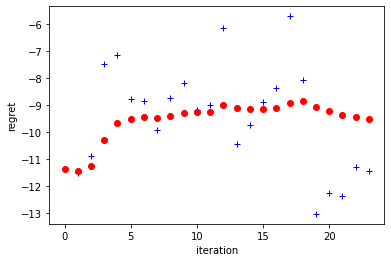

Optimal action: 2


In [21]:
# Try it with two arms and small difference between the mean values
# What are the required number of rounds to find the best action?
k      = 2
m      = 10
mu     = np.arange(0,k*m,0.1)
rounds = 5
experiment_etc(k, mu, m, rounds)

<div class="alert alert-block alert-success">
<b>Success:</b> With minimal difference between mean values we see low regret in lesser number of iterations. The optimal action also shows the same.

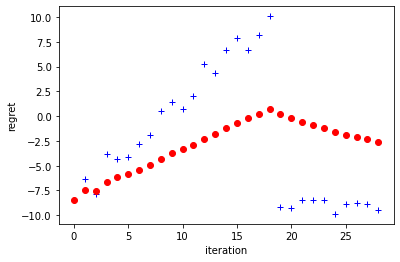

Optimal action: 2


In [22]:
# Try it with two arms and big difference between the mean values
# What are the required number of rounds to find the best action?
k      = 2
m      = 10
mu     = np.arange(0,k*m, 1)
rounds = 10
experiment_etc(k, mu, m, rounds)

<div class="alert alert-block alert-success">
<b>Success:</b> The regret is getting low after explorations of more than 15 iterations. So we need more rounds when difference in mean is large.

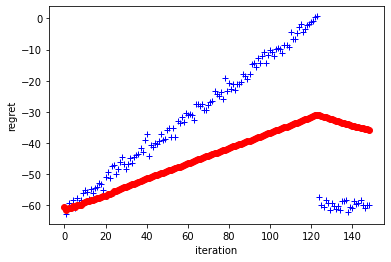

Optimal action: 5


In [23]:
# Try it with five arms and small differences among the mean values
# What are the required number of rounds to find the best action?
k      = 5
m      = 25
mu     = np.arange(0,k*m,0.5)
rounds = 25
experiment_etc(k, mu, m, rounds)

<div class="alert alert-block alert-success">
<b>Success:</b> The regret is getting low after explorations of more than 120 iterations. Thought the optimal action is low we need high number of rounds to get the low value.

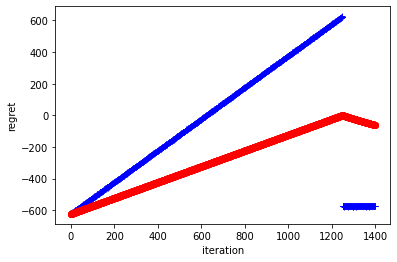

Optimal action: 50


In [24]:
# Try it with fifty arms and small differences among the mean values
# What are the required number of rounds to find the best action?
k      = 50
m      = 25
mu     = np.arange(0,k*m,1)
rounds = 150
experiment_etc(k, mu, m, rounds)

<div class="alert alert-block alert-success">
<b>Success:</b> The regret is getting low after explorations of more than 1200 iterations. We need more iterations in general more difference in mean values.

**OBSERVATIONS**
<div class="alert alert-block alert-warning">

- The following values shows we need more rounds of iterations when we have large difference in mean values
    
- The whole process converges with respect to normal distribution of the mean values
    
- The process can be said as "expectation maximisation" or EM process of matching the optimal distribution of highest reward

</div>

### UCB use-cases

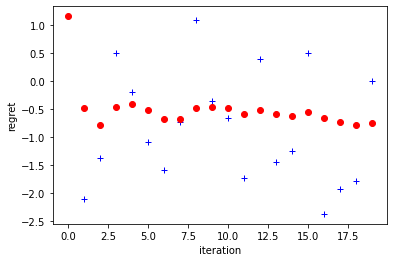

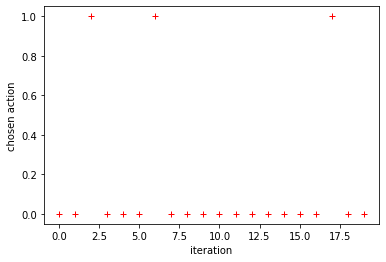

In [25]:
# Try it with two arms and small difference between the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta? 
k      = 2
mu     = np.arange(0,k,0.1)
delta  = 0.25
rounds = 20
experiment_ucb(k = k, mu = mu, delta = delta, rounds = rounds)

<div class="alert alert-block alert-success">
<b>Success:</b> With minimal difference between mean values we see low regret in lesser number of iterations. Delta is having minimum effect on the result.
    Here, we see the random action drops to minimum with more number of iterations.

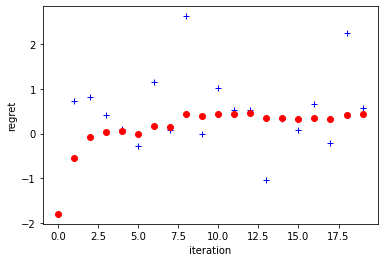

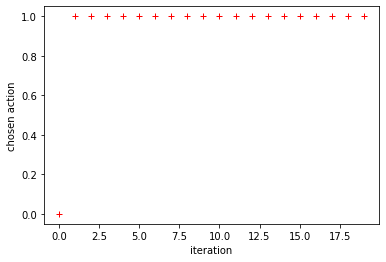

In [26]:
# Try it with two arms and big difference between the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta? 
k      = 2
mu     = np.arange(0,k,1)
delta  = 0.5
rounds = 20
experiment_ucb(k = k, mu = mu, delta = delta, rounds = rounds)

<div class="alert alert-block alert-success">
<b>Success:</b> Here we need some value iterations to converge to the best actions. Althought we acheive constant best action after some rounds in exploitation but the regret tends to increase.

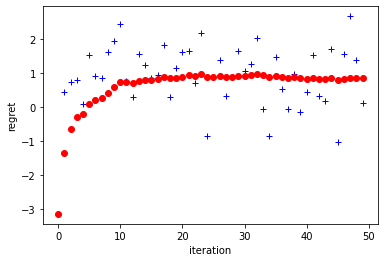

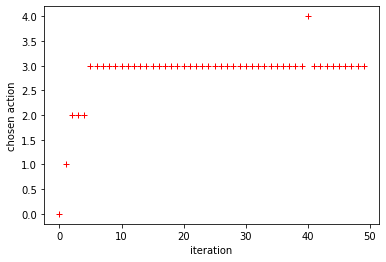

In [27]:
# Try it with five arms and small differences among the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta? 
k      = 5
mu     = np.arange(0,k,1)
delta  = 0.5
rounds = 50
experiment_ucb(k = k, mu = mu, delta = delta, rounds = rounds)

<div class="alert alert-block alert-success">
<b>Success:</b> The choosen action and regret has been showing no effect due to delta value. Rounds of more than 10 are required to get exploited optimal reward.

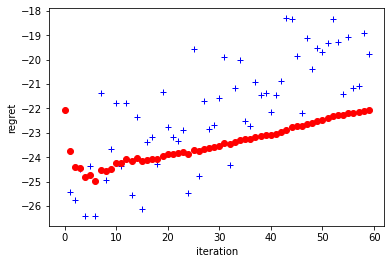

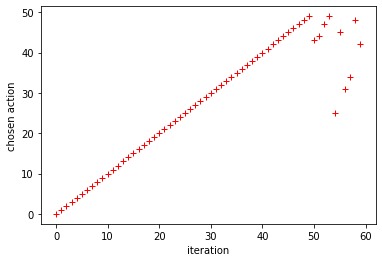

In [28]:
# Try it with fifty arms and small differences among the mean values
# What are the required number of rounds to find the best action?
# How the result changes with delta?
k      = 50
mu     = np.arange(0,k,0.1)
delta  = 0.75
rounds = 60
experiment_ucb(k = k, mu = mu, delta = delta, rounds = rounds)

<div class="alert alert-block alert-success">
<b>Success:</b> The regret curve shows increase after few rounds. The choosen random action drops after around 50 rounds

**OBSERVATIONS**
<div class="alert alert-block alert-warning">

There has been no such effect due to varying delta. The exploration of arms gets in general very high reward in the begining and as we move forward we get more regret.
    

</div>